# ***Data Preparation***

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score


In [ ]:
# Load the datasets
customers_df = pd.read_csv('customers_churn.csv')
interactions_df = pd.read_csv('interactions_churn.csv')

In [ ]:
customers_df.head()

,user_id,name,email,signup_date,location,age,gender,loyalty_score,last_order_date,average_order_value,total_orders
0,1,Todd Ochoa,amy71@example.com,2023-05-23,Paigeborough,63,M,41,2024-06-25,406.72,10
1,2,Julie White,raymond32@example.net,2023-11-08,Jackland,62,M,72,2024-04-14,110.36,7
2,3,Jamie Woods,dominiquebrown@example.net,2023-03-02,East Mitchell,40,F,22,2023-12-25,458.29,2
3,4,Jose Ponce,vincentanthony@example.org,2024-03-13,North Danielleside,60,F,39,2024-06-15,NaN,4
4,5,Kayla Lewis,williamcaldwell@example.net,2022-11-28,Kennedyfort,49,M,32,2024-03-09,390.95,9


In [ ]:
interactions_df.head()

,interaction_id,user_id,product_id,interaction_type,interaction_date
0,1,25,2,purchase,2023-08-20
1,2,94,40,review,2023-09-08
2,3,14,19,view,2023-07-29
3,4,67,14,purchase,2024-03-02
4,5,29,42,review,2023-09-18


Handling missing values

In [ ]:
# 1. Handling missing values in 'average_order_value'
# Filling missing values with the mean of the column
avg_order_value_mean = customers_df['average_order_value'].mean()
customers_df['average_order_value'].fillna(avg_order_value_mean, inplace=True)


# 2. Filtering out 'unknown' values in 'interaction_type'
interactions_df_clean = interactions_df[interactions_df['interaction_type'] != 'unknown']


# 3. Ensuring 'last_order_date' and 'interaction_date' are in datetime format
customers_df['last_order_date'] = pd.to_datetime(customers_df['last_order_date'], format='%Y-%m-%d')
interactions_df_clean['interaction_date'] = pd.to_datetime(interactions_df_clean['interaction_date'], format='%Y-%m-%d')


<ipython-input-30-cb9ed0ea43ae>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_df_clean['interaction_date'] = pd.to_datetime(interactions_df_clean['interaction_date'], format='%Y-%m-%d')


In [ ]:
# 4. Identifying outliers in 'loyalty_score' and 'total_orders' using the IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]
# Detecting outliers in 'loyalty_score'
loyalty_score_outliers = detect_outliers_iqr(customers_df, 'loyalty_score')

# Detecting outliers in 'total_orders'
total_orders_outliers = detect_outliers_iqr(customers_df, 'total_orders')

# Results
print("Outliers in 'loyalty_score':")
print(loyalty_score_outliers)
print("\nOutliers in 'total_orders':")
print(total_orders_outliers)



Outliers in 'loyalty_score':
Empty DataFrame
Columns: [user_id, name, email, signup_date, location, age, gender, loyalty_score, last_order_date, average_order_value, total_orders]
Index: []

Outliers in 'total_orders':
Empty DataFrame
Columns: [user_id, name, email, signup_date, location, age, gender, loyalty_score, last_order_date, average_order_value, total_orders]
Index: []


# ***Feature Engineering***

In [ ]:
# 1. Recency: Calculate the number of days since the customer's last order
current_date = pd.to_datetime("2024-09-14")  # Assuming current date is 2024-09-14
customers_df['last_order_date'] = pd.to_datetime(customers_df['last_order_date'], format='%Y-%m-%d')
customers_df['recency_days'] = (current_date - customers_df['last_order_date']).dt.days


In [ ]:
# 2. Monetary: Calculate total monetary value (average_order_value * total_orders)
customers_df['monetary_value'] = customers_df['average_order_value'] * customers_df['total_orders']


In [ ]:
# 3. Engagement Metrics: Calculate number of 'reviews' and 'views' per customer
interaction_engagement = interactions_df.groupby(['user_id', 'interaction_type']).size().unstack(fill_value=0)
interaction_engagement['total_engagements'] = interaction_engagement.sum(axis=1)


In [ ]:
# 4. Merge the interaction metrics with the customers dataframe on 'user_id'
customers_enriched_df = customers_df.merge(interaction_engagement, left_on='user_id', right_index=True, how='left')


In [ ]:
# Check for missing values in the merged dataset
missing_values = customers_enriched_df.isnull().sum()

# Display columns with missing values
print(missing_values)

user_id                0
name                   0
email                  0
signup_date            0
location               0
age                    0
gender                 0
loyalty_score          0
last_order_date        0
average_order_value    0
total_orders           0
recency_days           0
monetary_value         0
add_to_cart            1
purchase               1
review                 1
unknown                1
view                   1
total_engagements      1
dtype: int64


In [ ]:
# Fill missing engagement data with zeros (for users without interactions)
customers_enriched_df.fillna(0, inplace=True)


# Get the shape of the DataFrame
rows, columns = customers_enriched_df.shape

print(f'Number of rows: {rows}')
print(f'Number of columns: {columns}')

# Results
customers_enriched_df.head()


Number of rows: 100
Number of columns: 19


,user_id,name,email,signup_date,location,age,gender,loyalty_score,last_order_date,average_order_value,total_orders,recency_days,monetary_value,add_to_cart,purchase,review,unknown,view,total_engagements
0,1,Todd Ochoa,amy71@example.com,2023-05-23,Paigeborough,63,M,41,2024-06-25,406.720000,10,81,4067.200000,2.0,3.0,2.0,0.0,4.0,11.0
1,2,Julie White,raymond32@example.net,2023-11-08,Jackland,62,M,72,2024-04-14,110.360000,7,153,772.520000,0.0,1.0,4.0,0.0,3.0,8.0
2,3,Jamie Woods,dominiquebrown@example.net,2023-03-02,East Mitchell,40,F,22,2023-12-25,458.290000,2,264,916.580000,1.0,4.0,3.0,0.0,1.0,9.0
3,4,Jose Ponce,vincentanthony@example.org,2024-03-13,North Danielleside,60,F,39,2024-06-15,257.121889,4,91,1028.487556,1.0,1.0,0.0,0.0,1.0,3.0
4,5,Kayla Lewis,williamcaldwell@example.net,2022-11-28,Kennedyfort,49,M,32,2024-03-09,390.950000,9,189,3518.550000,5.0,3.0,6.0,0.0,4.0,18.0


# ***Insights***

 Churn Prediction Based on Recency

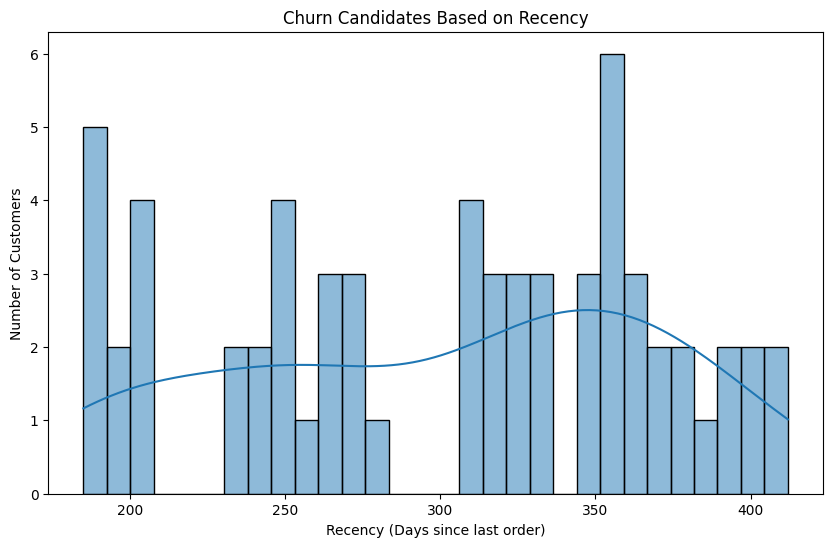

In [ ]:
# Churn Prediction Based on Recency
# Threshold: recency > 180 days (customers who haven't ordered in 6+ months)
churn_candidates = customers_enriched_df[customers_enriched_df['recency_days'] > 180]

# Plotting churn candidates based on recency
plt.figure(figsize=(10, 6))
sns.histplot(churn_candidates['recency_days'], bins=30, kde=True)
plt.title('Churn Candidates Based on Recency')
plt.xlabel('Recency (Days since last order)')
plt.ylabel('Number of Customers')
plt.show()


•	Engagement Opportunities:

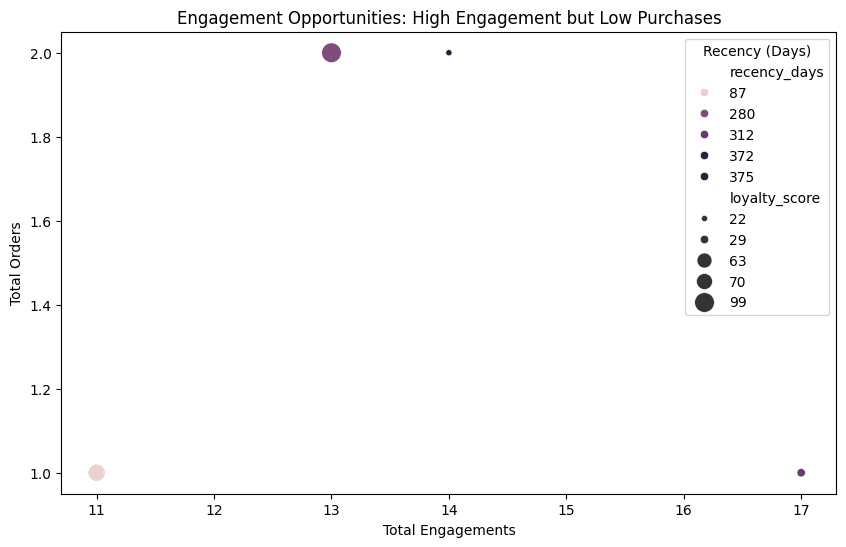

In [ ]:
# Engagement Opportunities: High engagements but low purchases
# Threshold: total_engagements > 10 and total_orders < 3
engagement_opportunities = customers_enriched_df[(customers_enriched_df['total_engagements'] > 10) &
                                                 (customers_enriched_df['total_orders'] < 3)]

# Plotting engagement opportunities
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_engagements', y='total_orders', hue='recency_days', size='loyalty_score', sizes=(20, 200),
                data=engagement_opportunities)
plt.title('Engagement Opportunities: High Engagement but Low Purchases')
plt.xlabel('Total Engagements')
plt.ylabel('Total Orders')
plt.legend(title='Recency (Days)')
plt.show()


Loyalty Program Adjustment:

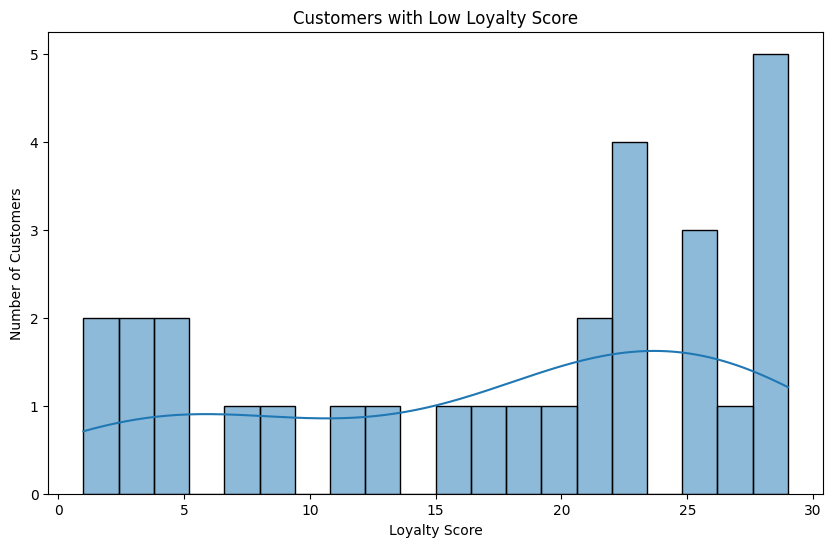

In [ ]:
# Loyalty Program Adjustment
# Threshold: loyalty_score < 30 (customers with low engagement)
low_loyalty_customers = customers_enriched_df[customers_enriched_df['loyalty_score'] < 30]

# Plotting low loyalty customers
plt.figure(figsize=(10, 6))
sns.histplot(low_loyalty_customers['loyalty_score'], bins=20, kde=True)
plt.title('Customers with Low Loyalty Score')
plt.xlabel('Loyalty Score')
plt.ylabel('Number of Customers')
plt.show()

# Strategy: Offer personalized rewards or loyalty bonuses to increase engagement.


High LTV at risk

In [ ]:
# Define High LTV customers (e.g., monetary_value > 5000 as a threshold)
high_ltv_customers = customers_enriched_df[customers_enriched_df['monetary_value'] > 4000]

# High LTV customers with churn indicators
# Criteria: High Recency (>180 days) OR Low loyalty score (<30) OR Decrease in total orders (<5)
high_ltv_at_risk = high_ltv_customers[(high_ltv_customers['recency_days'] > 180) |
                                      (high_ltv_customers['loyalty_score'] < 30) |
                                      (high_ltv_customers['total_orders'] < 5)]

# Display the high LTV customers at risk of churn
print(high_ltv_at_risk)


    user_id           name              email signup_date            location  \
26       27  Heather White  joy12@example.net  2023-01-08  North Cynthiashire   

    age gender  loyalty_score last_order_date  average_order_value  \
26   29      M             65      2024-03-10                450.2   

    total_orders  recency_days  monetary_value  add_to_cart  purchase  review  \
26             9           188          4051.8          2.0       2.0     2.0   

    unknown  view  total_engagements  
26      0.0   3.0                9.0  


# ***Random Forest Classifier***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Creating a churn label based on thresholds (e.g., high recency, low orders, etc.)
customers_enriched_df['churn_label'] = ((customers_enriched_df['recency_days'] > 180) |
                                        (customers_enriched_df['loyalty_score'] < 30) |
                                        (customers_enriched_df['total_orders'] < 5)).astype(int)

# Features and target variable
X = customers_enriched_df[['recency_days', 'loyalty_score', 'total_orders', 'monetary_value', 'total_engagements']]
y = customers_enriched_df['churn_label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.96      0.98        24

    accuracy                           0.97        30
   macro avg       0.93      0.98      0.95        30
weighted avg       0.97      0.97      0.97        30



ROC CURVE

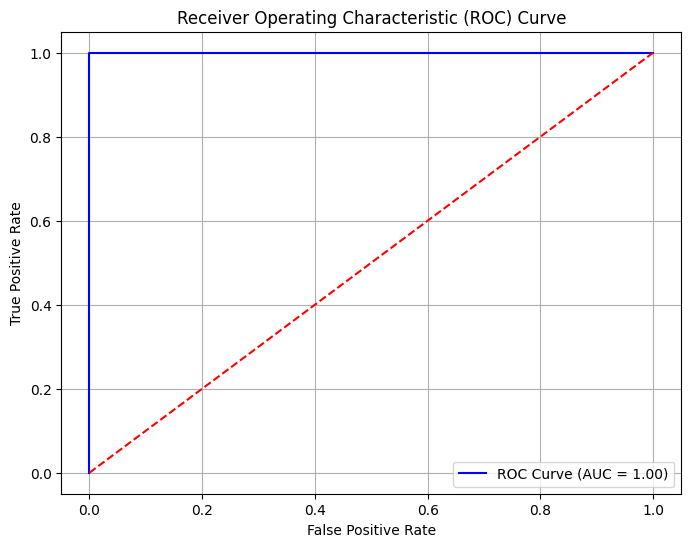

AUC Score: 1.00


In [ ]:
# Calculate predicted probabilities for the test set (for ROC curve)
y_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Dashed diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print the AUC score
print(f'AUC Score: {auc_score:.2f}')


In [ ]:
# Predict churn labels (0 for no churn, 1 for churn)
y_pred = rf.predict(X_test)

# Convert X_test to a DataFrame to match the original customer data for easier identification
X_test_df = X_test.copy()
X_test_df['predicted_churn'] = y_pred
X_test_df['actual_churn'] = y_test.values  # Add actual churn label for comparison

# Filter the customers predicted to churn (predicted_churn = 1)
predicted_churn_customers = X_test_df[X_test_df['predicted_churn'] == 1]

# Print the customers predicted to churn
print("Customers Predicted to Churn:")
print(predicted_churn_customers)

# Optionally, you can display both the predicted and actual churn to compare
print("\nComparison of Predicted and Actual Churn:")
print(X_test_df[['predicted_churn', 'actual_churn']].head())


Customers Predicted to Churn:
    recency_days  loyalty_score  total_orders  monetary_value  \
83           275             15             7      259.350000   
53           194             43             1      233.480000   
70           242             73             8     3730.800000   
44           329             58             1      367.890000   
39           327             63             5     1343.450000   
22            87             63             1      257.121889   
80           205             82             6     1066.380000   
10           176             95             4     1588.920000   
18           316             21             3      582.060000   
30           312             20            10     2976.500000   
73           335             34             7     1605.380000   
33           346             78             4      441.560000   
4            189             32             9     3518.550000   
77           185             64             2      293.72000